# ***Project 2***

Investigating whether Permutation Entropy and Complexity will be helpful in analysing whether a subject is intoxicated or not.

Dataset includes:
1. Accelerometer data of the person in all three directions
2. TAC values of all subjects.

  if the TAC Value is >0.08, the subject is classified as intoxicated, else not intoxicated

This cell contains the functions used for calculating

1. Ordinal Patterns
2. Permutation Entropy
3. Complexity

In [ ]:
''' This module has essential functions supporting
fast and effective computation of permutation entropy and
its different variations.'''
import numpy as np


def s_entropy(freq_list):
    ''' This function computes the shannon entropy of a given frequency distribution.
    USAGE: shannon_entropy(freq_list)
    ARGS: freq_list = Numeric vector representing the frequency distribution
    OUTPUT: A numeric value representing shannon's entropy'''
    freq_list = [element for element in freq_list if element != 0]
    sh_entropy = 0.0
    for freq in freq_list:
        sh_entropy += freq * np.log(freq)
    sh_entropy = -sh_entropy
    return(sh_entropy)

def ordinal_patterns(ts, embdim, embdelay):
    ''' This function computes the ordinal patterns of a time series for a given embedding dimension and embedding delay.
    USAGE: ordinal_patterns(ts, embdim, embdelay)
    ARGS: ts = Numeric vector representing the time series, embdim = embedding dimension (3<=embdim<=7 prefered range), embdelay =  embdding delay
    OUPTUT: A numeric vector representing frequencies of ordinal patterns'''
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    permutation = np.argsort(partition)
    idx = _hash(permutation)

    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = (idx == i).sum()
    return list(counts[counts != 0].astype(int))

def _hash(x):
    m, n = x.shape
    if n == 1:
        return np.zeros(m)
    return np.sum(np.apply_along_axis(lambda y: y < x[:, 0], 0, x), axis=1) * np.math.factorial(n-1) + _hash(x[:, 1:])


def p_entropy(op):
    ordinal_pat = op
    max_entropy = np.log(len(ordinal_pat))
    p = np.divide(np.array(ordinal_pat), float(sum(ordinal_pat)))
    return(s_entropy(p)/max_entropy)

def j_complexity(op):
    ''' This function computes the complexity of a time series defined as: Comp_JS = Q_o * JSdivergence * pe
    Q_o = Normalizing constant
    JSdivergence = Jensen-Shannon divergence
    pe = permutation entopry
    ARGS: ordinal pattern'''
    if len(op) == 0:
      return 0
    pe = p_entropy(op)
    constant1 = (0.5+((1 - 0.5)/len(op)))* np.log(0.5+((1 - 0.5)/len(op)))
    constant2 = ((1 - 0.5)/len(op))*np.log((1 - 0.5)/len(op))*(len(op) - 1)
    constant3 = 0.5*np.log(len(op))
    Q_o = -1/(constant1+constant2+constant3)

    temp_op_prob = np.divide(op, sum(op))
    temp_op_prob2 = (0.5*temp_op_prob)+(0.5*(1/len(op)))
    JSdivergence = (s_entropy(temp_op_prob2) - 0.5 * s_entropy(temp_op_prob) - 0.5 * np.log(len(op)))
    Comp_JS = Q_o * JSdivergence * pe
    return(Comp_JS)

def weighted_ordinal_patterns(ts, embdim, embdelay):
    m, t = embdim, embdelay
    x = ts if isinstance(ts, np.ndarray) else np.array(ts)

    tmp = np.zeros((x.shape[0], m))
    for i in range(m):
        tmp[:, i] = np.roll(x, i*t)
    partition = tmp[(t*(m-1)):, :]
    xm = np.mean(partition, axis=1)
    weight = np.mean((partition - xm[:, None])**2, axis=1)
    permutation = np.argsort(partition)
    idx = _hash(permutation)
    counts = np.zeros(np.math.factorial(m))
    for i in range(counts.shape[0]):
        counts[i] = sum(weight[i == idx])

    return list(counts[counts != 0])

Mounting g-drive for dataset and reading necessary headers

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set working directory
%cd /content/drive/MyDrive/NEU-MS-DAE/IE6400-FDA/Project2

/content/drive/MyDrive/NEU-MS-DAE/IE6400-FDA/Project2


In [ ]:
# Import necessary headers
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Ignoring warnings if any

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

TAC Values for different subjects in the folder: clean_tac

Reading the filenames and headers

In [ ]:
csv_folder_path = '/content/drive/MyDrive/NEU-MS-DAE/IE6400-FDA/Project2/clean_tac'
csv_files = [f for f in os.listdir(csv_folder_path) if f.endswith('.csv')]
csv_files

['SA0297_clean_TAC.csv',
 'PC6771_clean_TAC.csv',
 'JB3156_clean_TAC.csv',
 'HV0618_clean_TAC.csv',
 'CC6740_clean_TAC.csv',
 'MC7070_clean_TAC.csv',
 'BK7610_clean_TAC.csv',
 'MJ8002_clean_TAC.csv',
 'BU4707_clean_TAC.csv',
 'JR8022_clean_TAC.csv',
 'DC6359_clean_TAC.csv',
 'DK3500_clean_TAC.csv',
 'SF3079_clean_TAC.csv']

In [ ]:
csv_headers = [csv[0:6] for csv in csv_files]
csv_headers

['SA0297',
 'PC6771',
 'JB3156',
 'HV0618',
 'CC6740',
 'MC7070',
 'BK7610',
 'MJ8002',
 'BU4707',
 'JR8022',
 'DC6359',
 'DK3500',
 'SF3079']

Reading the accelerometr data for all 13 pids

In [ ]:
# Reading acc data
df_acc = pd.read_csv('all_accelerometer_data_pids_13.csv')

Calculating the resultant vector

Converting timestamp to seconds, as the given time is in milliseconds.

In [ ]:
# Calculatig resultant vector
df_acc['resultant'] = (df_acc['x']**2 + df_acc['y']**2 + df_acc['z']**2)**0.5

# Converting timestamp to seconds
df_acc['timestamp'] = df_acc['time']//1000

In [ ]:
df_acc

,time,pid,x,y,z,resultant,timestamp
0,0,JB3156,0.000000,0.000000,0.000000,0.000000,0
1,0,CC6740,0.000000,0.000000,0.000000,0.000000,0
2,1493733882409,SA0297,0.075800,0.027300,-0.010200,0.081209,1493733882
3,1493733882455,SA0297,-0.035900,0.079400,0.003700,0.087217,1493733882
4,1493733882500,SA0297,-0.242700,-0.086100,-0.016300,0.258035,1493733882
...,...,...,...,...,...,...,...
14057562,1493829248196,CC6740,-0.133956,0.124726,-0.010736,0.183347,1493829248
14057563,1493829248220,CC6740,-0.100764,0.180872,0.046449,0.212192,1493829248
14057564,1493829248245,CC6740,-0.131853,0.195934,0.181088,0.297604,1493829248
14057565,1493829248270,CC6740,-0.149704,0.194482,0.202393,0.318115,1493829248


***Function Definitions***

In [ ]:
# Reading tac and merging with the acc data for each pid
def read_merge_file(pid, csv_file):
    tac = pd.read_csv(os.path.join(csv_folder_path, csv_file))
    tac['pid'] = pid
    acc = df_acc[df_acc['pid'] == pid]
    merged = pd.merge(acc, tac, on = 'timestamp')
    return merged

In [ ]:
# Sampling the time for each pid according to the sampling frequency: 40Hz (Ref: ReadMe)
def preprocess_acc_tac(merged):
  t = np.arange(merged['x'].size)/40
  return t

In [ ]:
# Visulizing the acc and tac values for each pid
def visualize_acc_tac(merged, time):

  # Create subplots
  fig, ax = plt.subplots(5, figsize=(15, 12), sharex=True)

  # Plotting x
  ax[0].plot(time, merged["x"], label="X", color="blue")
  ax[0].set_ylabel("X Acceleration")
  ax[0].legend()

  # Plotting y
  ax[1].plot(time, merged["y"], label="Y", color="green")
  ax[1].set_ylabel("Y Acceleration")
  ax[1].legend()

  # Plotting z
  ax[2].plot(time, merged["z"], label="Z", color="red")
  ax[2].set_ylabel("Z Acceleration")
  ax[2].legend()

  # Plotting resultant
  ax[3].plot(time, merged["resultant"], label="Resultant", color="purple")
  ax[3].set_ylabel("Resultant Acceleration")
  ax[3].legend()

  # Plotting TAC_Reading
  ax[4].plot(time, merged["TAC_Reading"], label="TAC Reading", color="orange")
  ax[4].axhline(y=0.08, color='r', linestyle='dotted', label="Threshold")
  ax[4].set_ylabel("TAC Reading")
  ax[4].set_xlabel("Time")
  ax[4].legend()

  # Adding a global title
  plt.suptitle("Sensor Data Analysis", fontsize=16)

  # Adjust layout
  plt.tight_layout()

  # Display the plot
  plt.show()

In [ ]:
# Calculating the permutation entropy and complexity values and matching it with unique TAC values for each pid
def cacl_permutation_complexity(merged, pid):
  tac_values = merged['TAC_Reading'].unique()

  for tac in tac_values:
    window = len(merged.index[merged['TAC_Reading'] == tac].tolist())
    permutation = []
    complexity = []
    pids = []
    for i in range(tac_values.size):
      s_index = i * window
      e_index = s_index + window
      df_w = merged['resultant'][s_index:e_index]
      op = ordinal_patterns(df_w, 3, 1)
      pe = p_entropy(op)
      cp = j_complexity(op)
      permutation.append(pe)
      complexity.append(cp)
      pids.append(pid)
  data = {'pid' : pids, 'p_entropy' : permutation, 'complexity' : complexity, 'tac' : tac_values}
  return data

In [ ]:
# Calling all the functions for complete dataframe building with Pid, P_Entropy, Complexity and TAC Values
def accelerometer_tac_analysis(csv_files):
  final_df = pd.DataFrame()
  datas = []
  for i, csv_files in enumerate(csv_files):
    print('\nReading TAC file of: ', csv_headers[i])
    print(csv_files)
    print('\nMerging with corresponding accelerometer data')
    df_acc_tac = read_merge_file(csv_headers[i], csv_files)
    df_acc_tac.loc[df_acc_tac.TAC_Reading > 0.08, "intoxicated"] = 1
    df_acc_tac.loc[df_acc_tac.TAC_Reading <= 0.08, "intoxicated"] = 0
    t = preprocess_acc_tac(df_acc_tac)
    print("\nVisualizing X, Y, Z, Resultant Acceleration Readings and Corresponding TAC Readings")
    visualize_acc_tac(df_acc_tac, t)
    data = cacl_permutation_complexity(df_acc_tac, csv_headers[i])
    data = pd.DataFrame(data)
    datas.append(data)
  for df in datas:
    final_df = pd.concat([final_df, df])
  return final_df

In [ ]:
df_perm_comp_data = pd.DataFrame()

Reading TAC file of:  SA0297
SA0297_clean_TAC.csv
Merding with corresponding accelerometer data


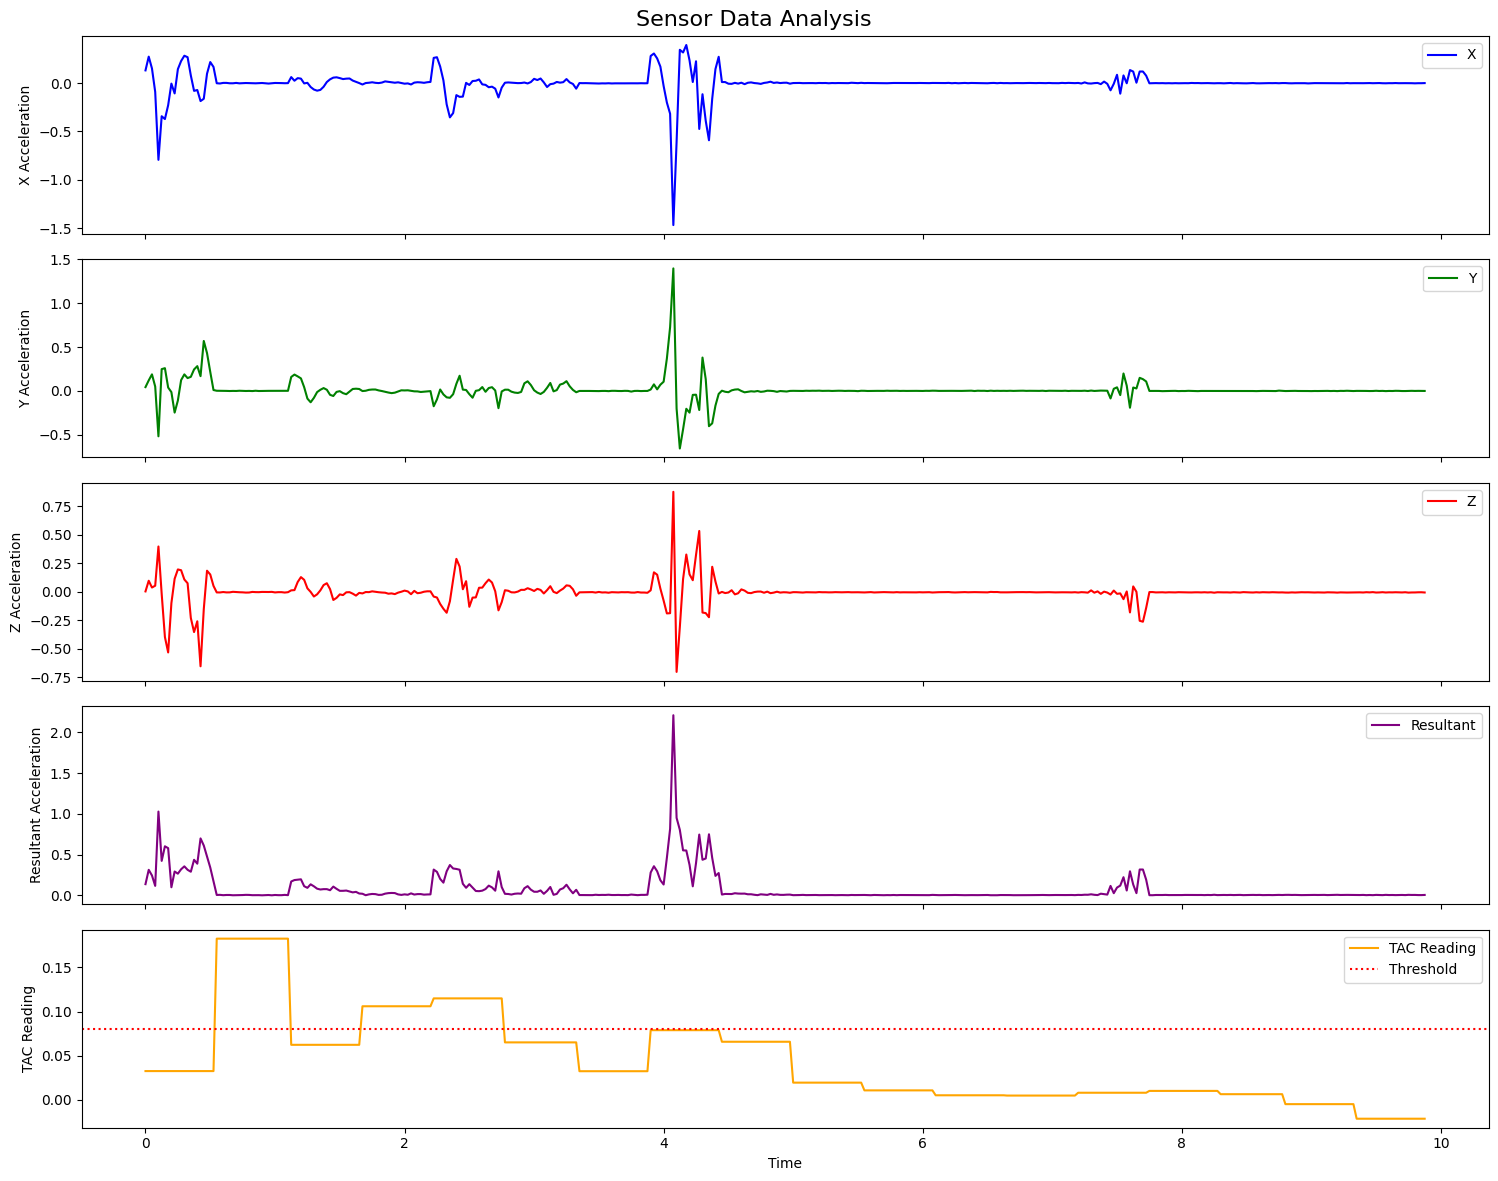

Reading TAC file of:  PC6771
PC6771_clean_TAC.csv
Merding with corresponding accelerometer data


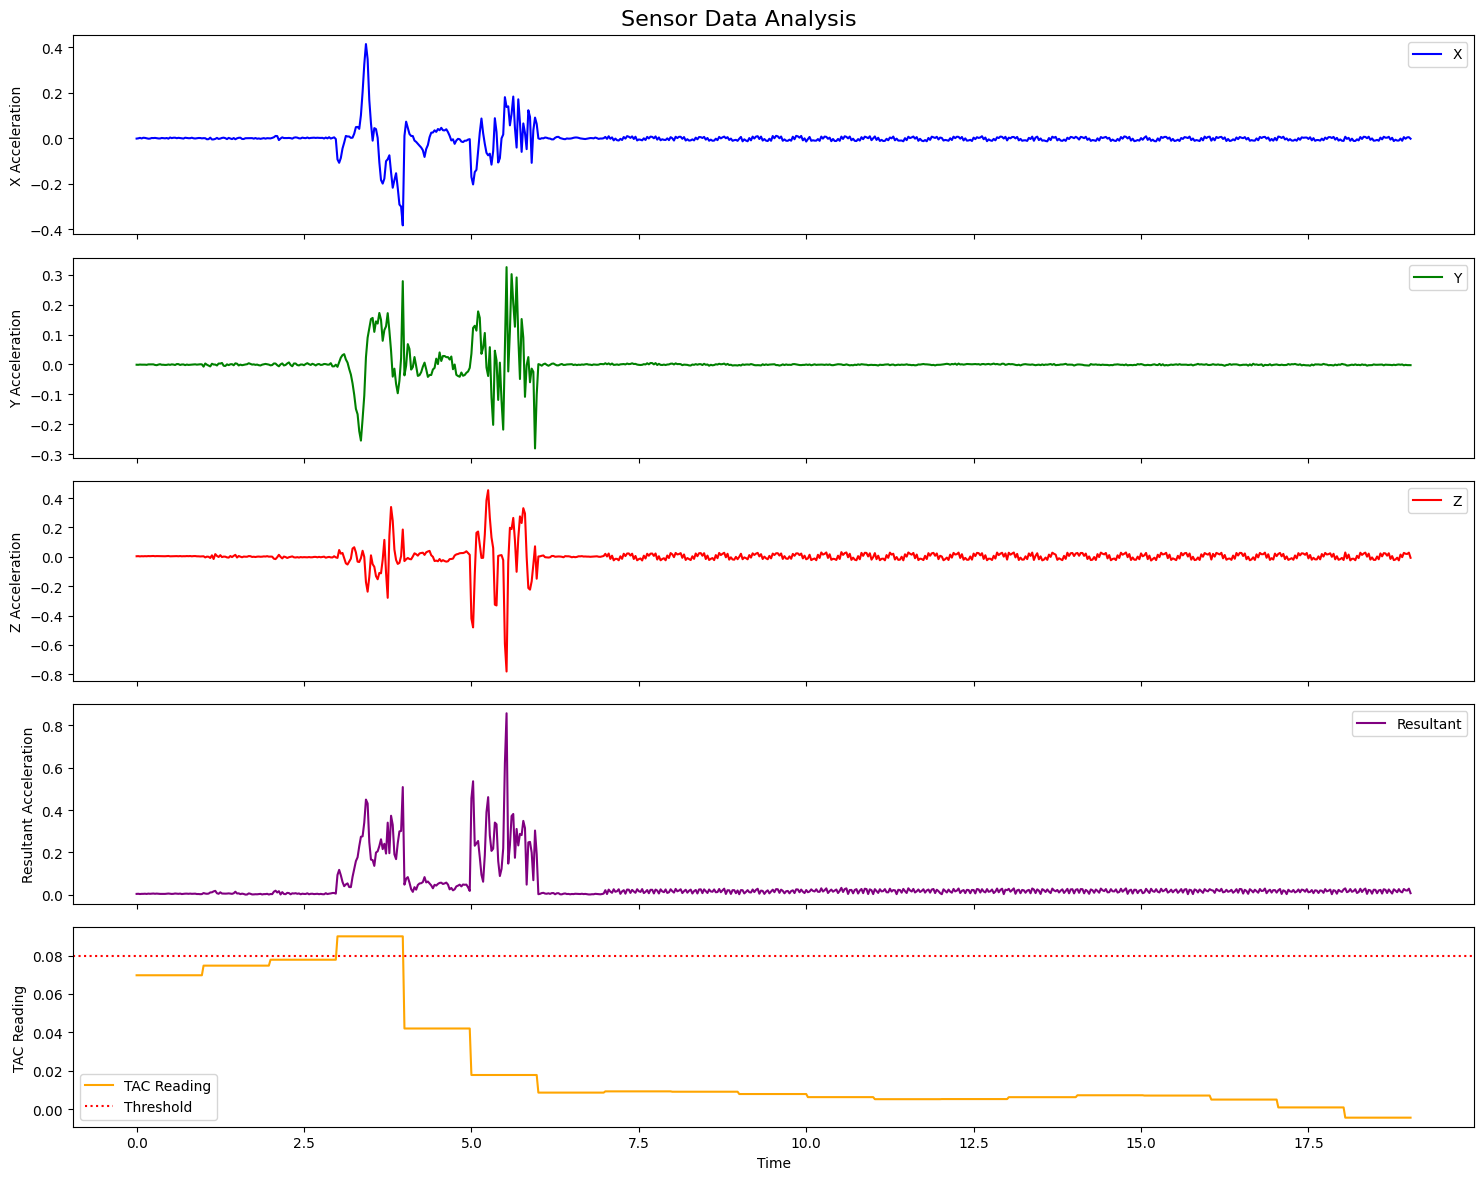

Reading TAC file of:  JB3156
JB3156_clean_TAC.csv
Merding with corresponding accelerometer data


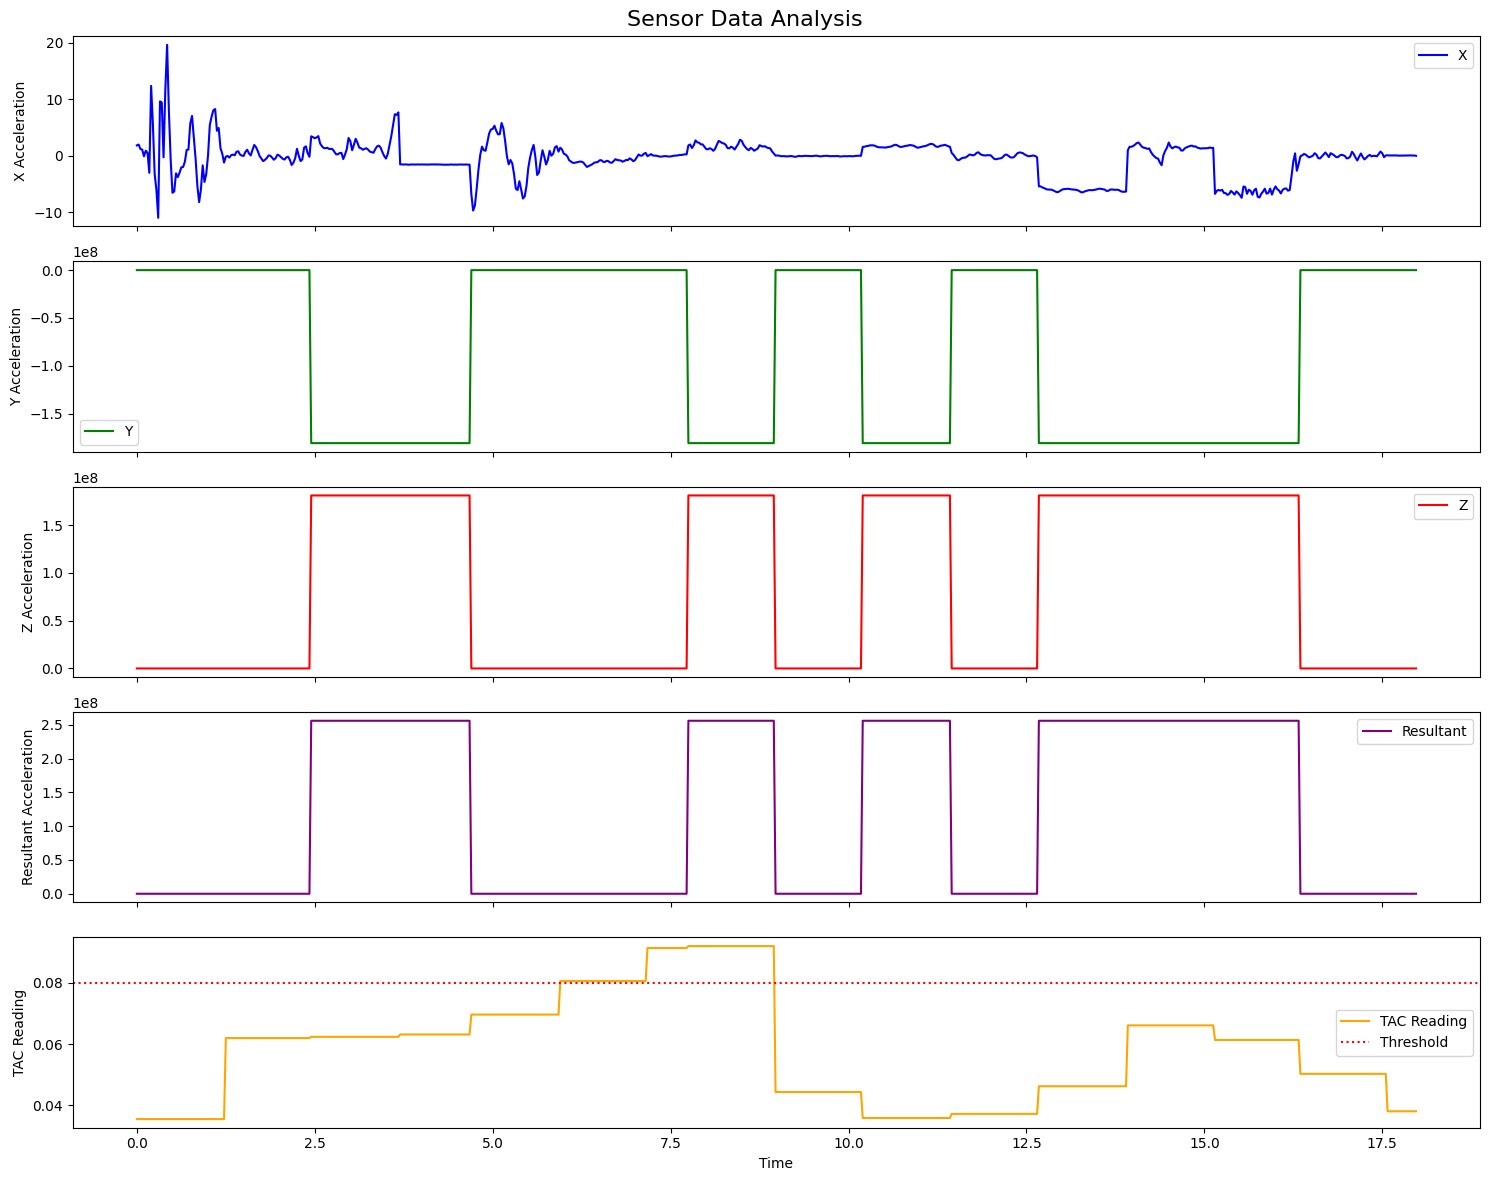

Reading TAC file of:  HV0618
HV0618_clean_TAC.csv
Merding with corresponding accelerometer data


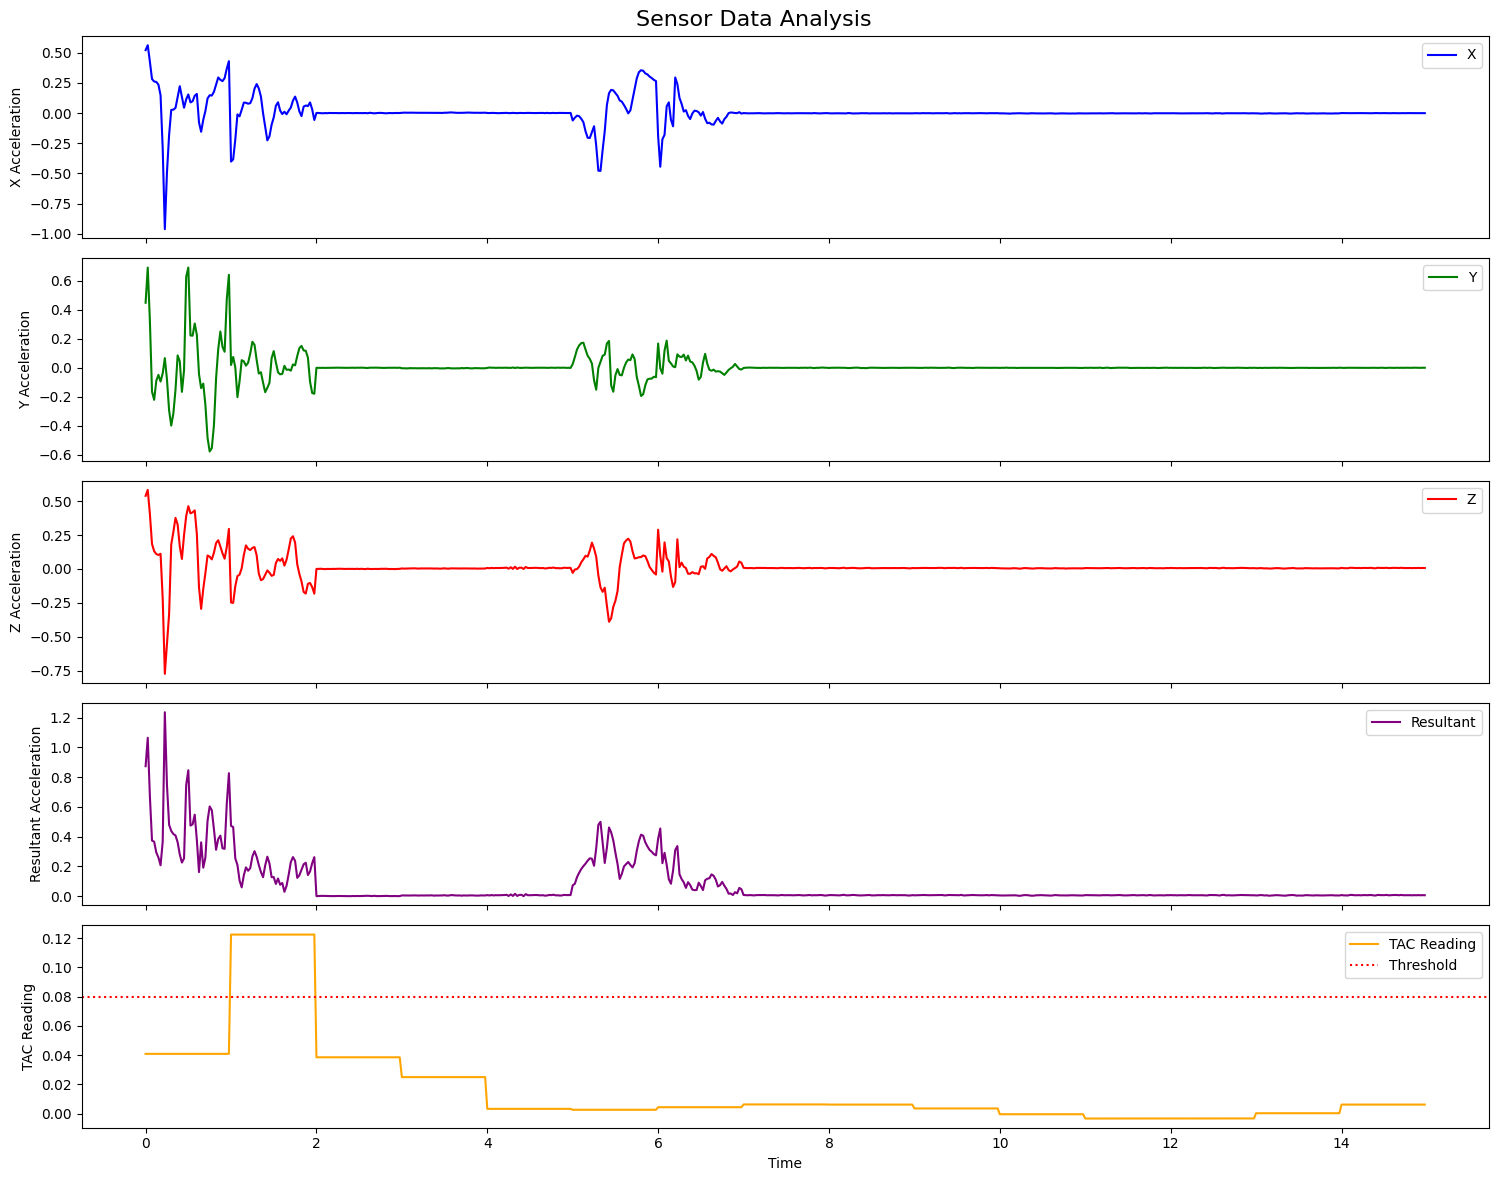

Reading TAC file of:  CC6740
CC6740_clean_TAC.csv
Merding with corresponding accelerometer data


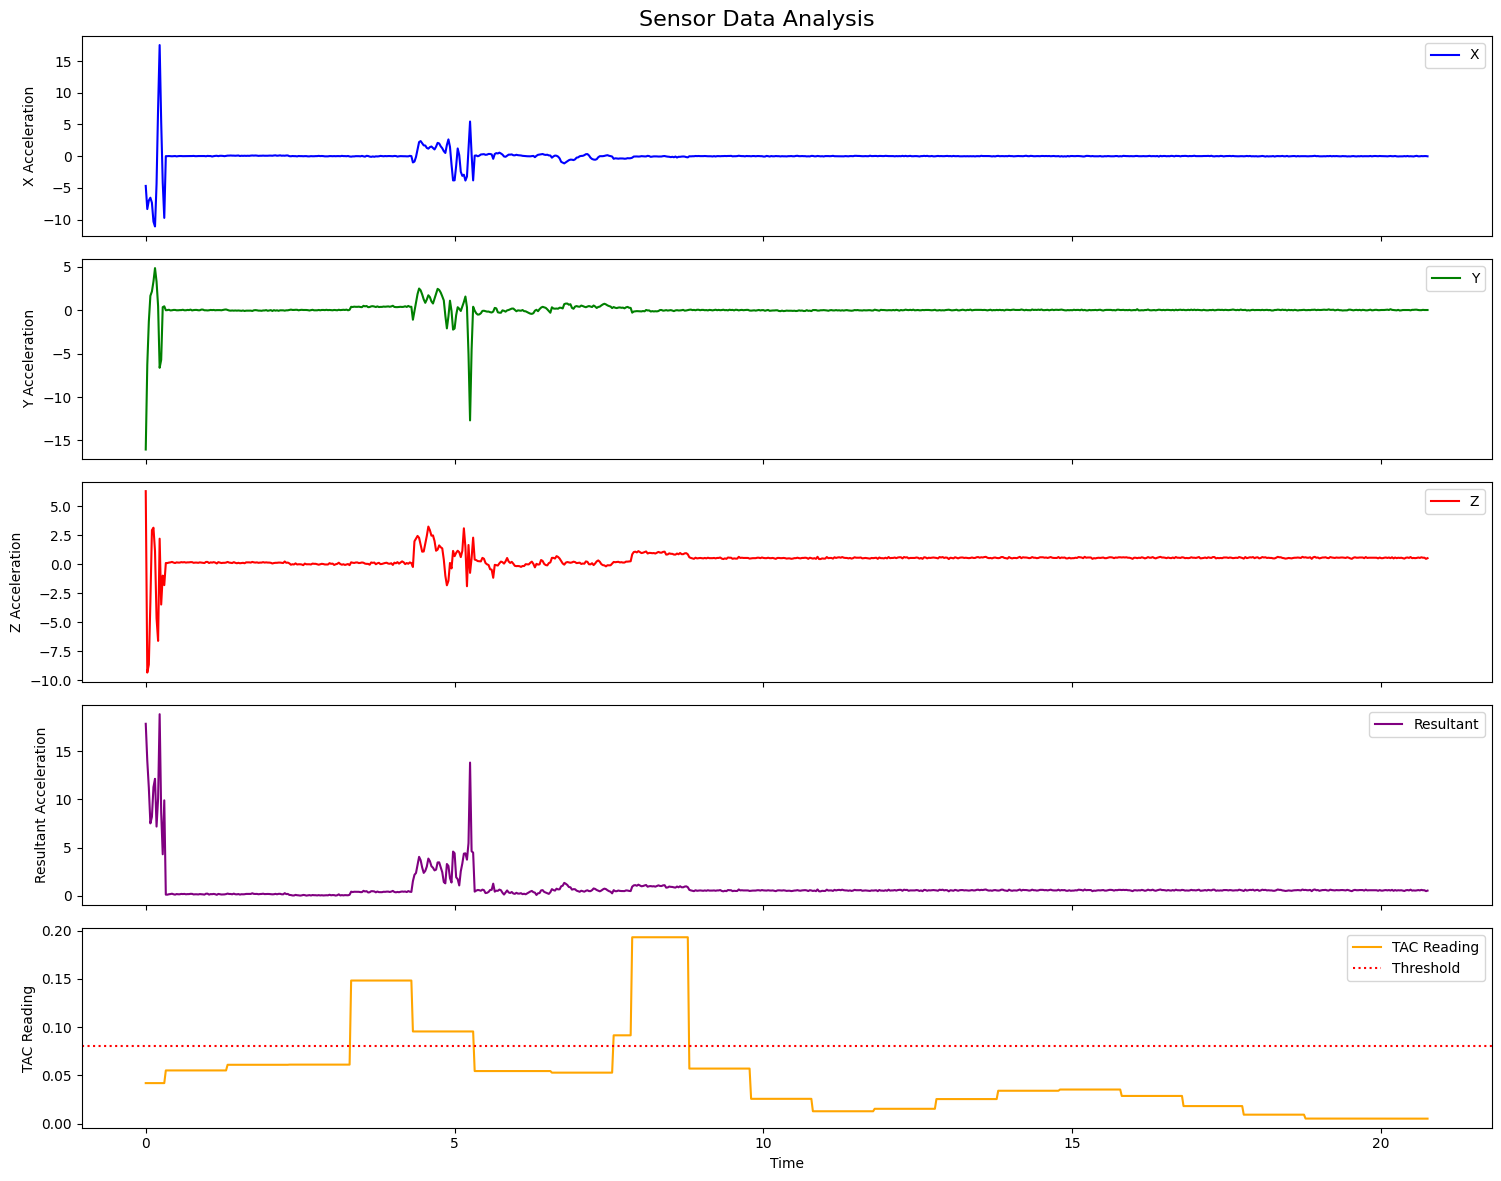

Reading TAC file of:  MC7070
MC7070_clean_TAC.csv
Merding with corresponding accelerometer data


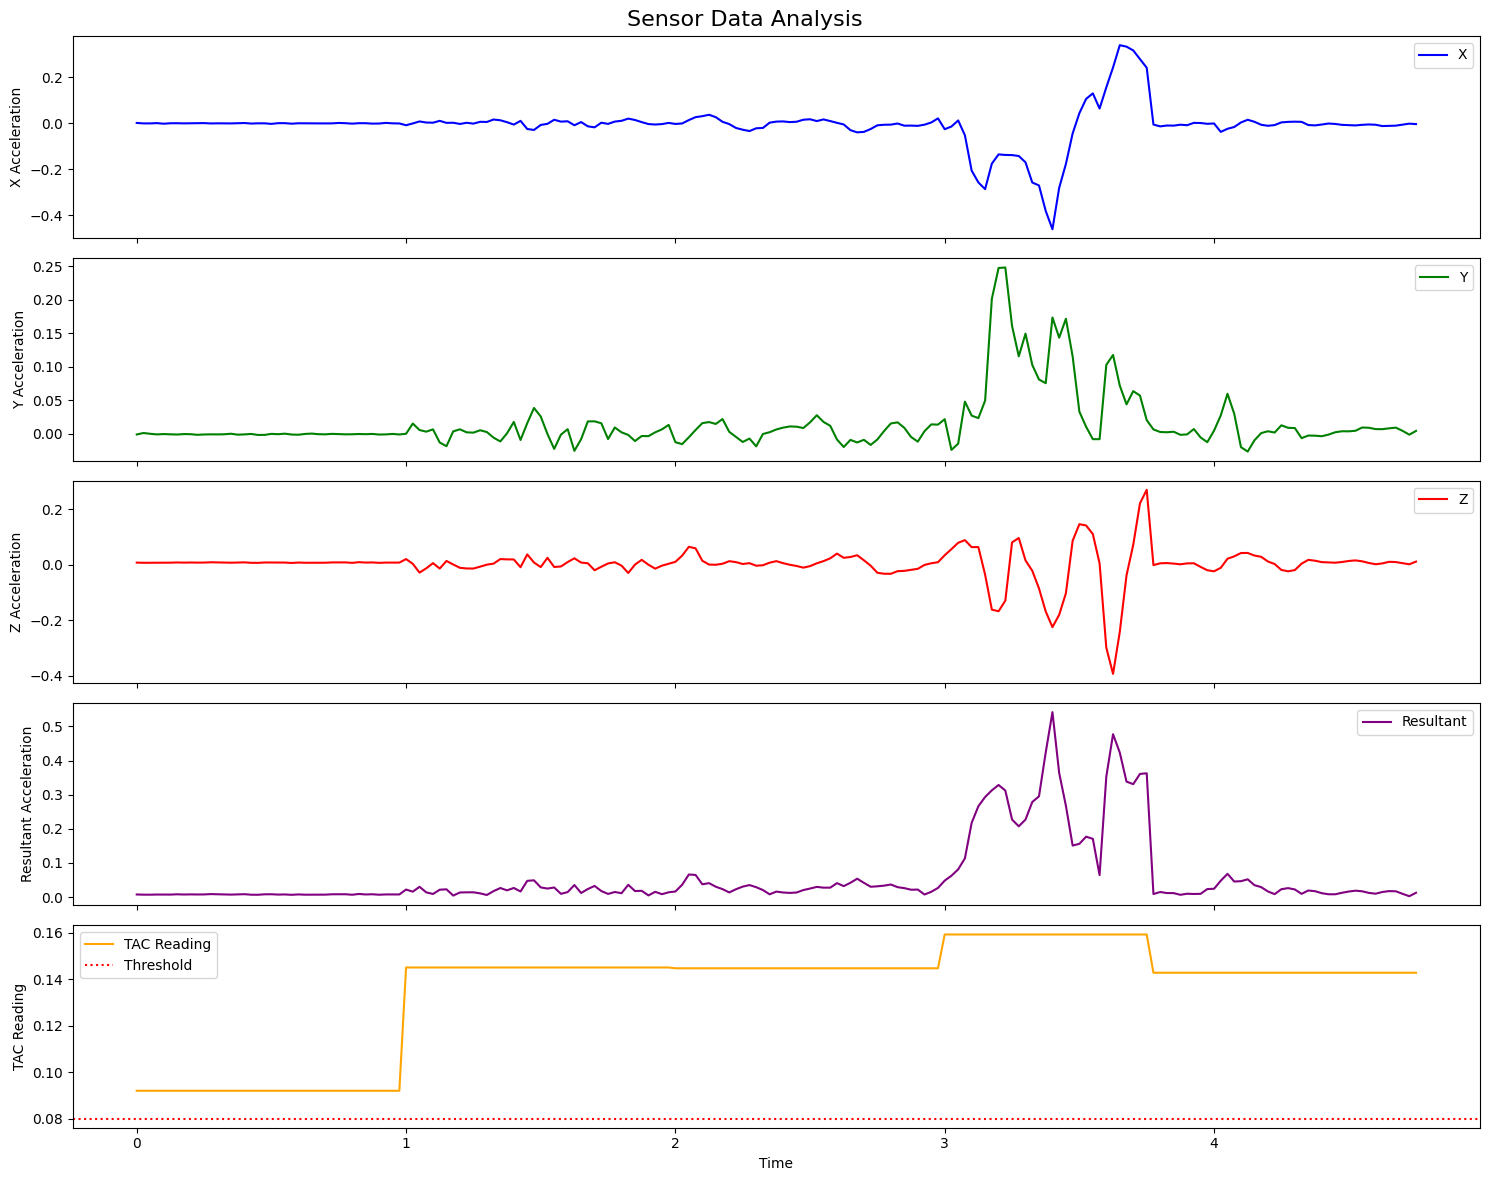

Reading TAC file of:  BK7610
BK7610_clean_TAC.csv
Merding with corresponding accelerometer data


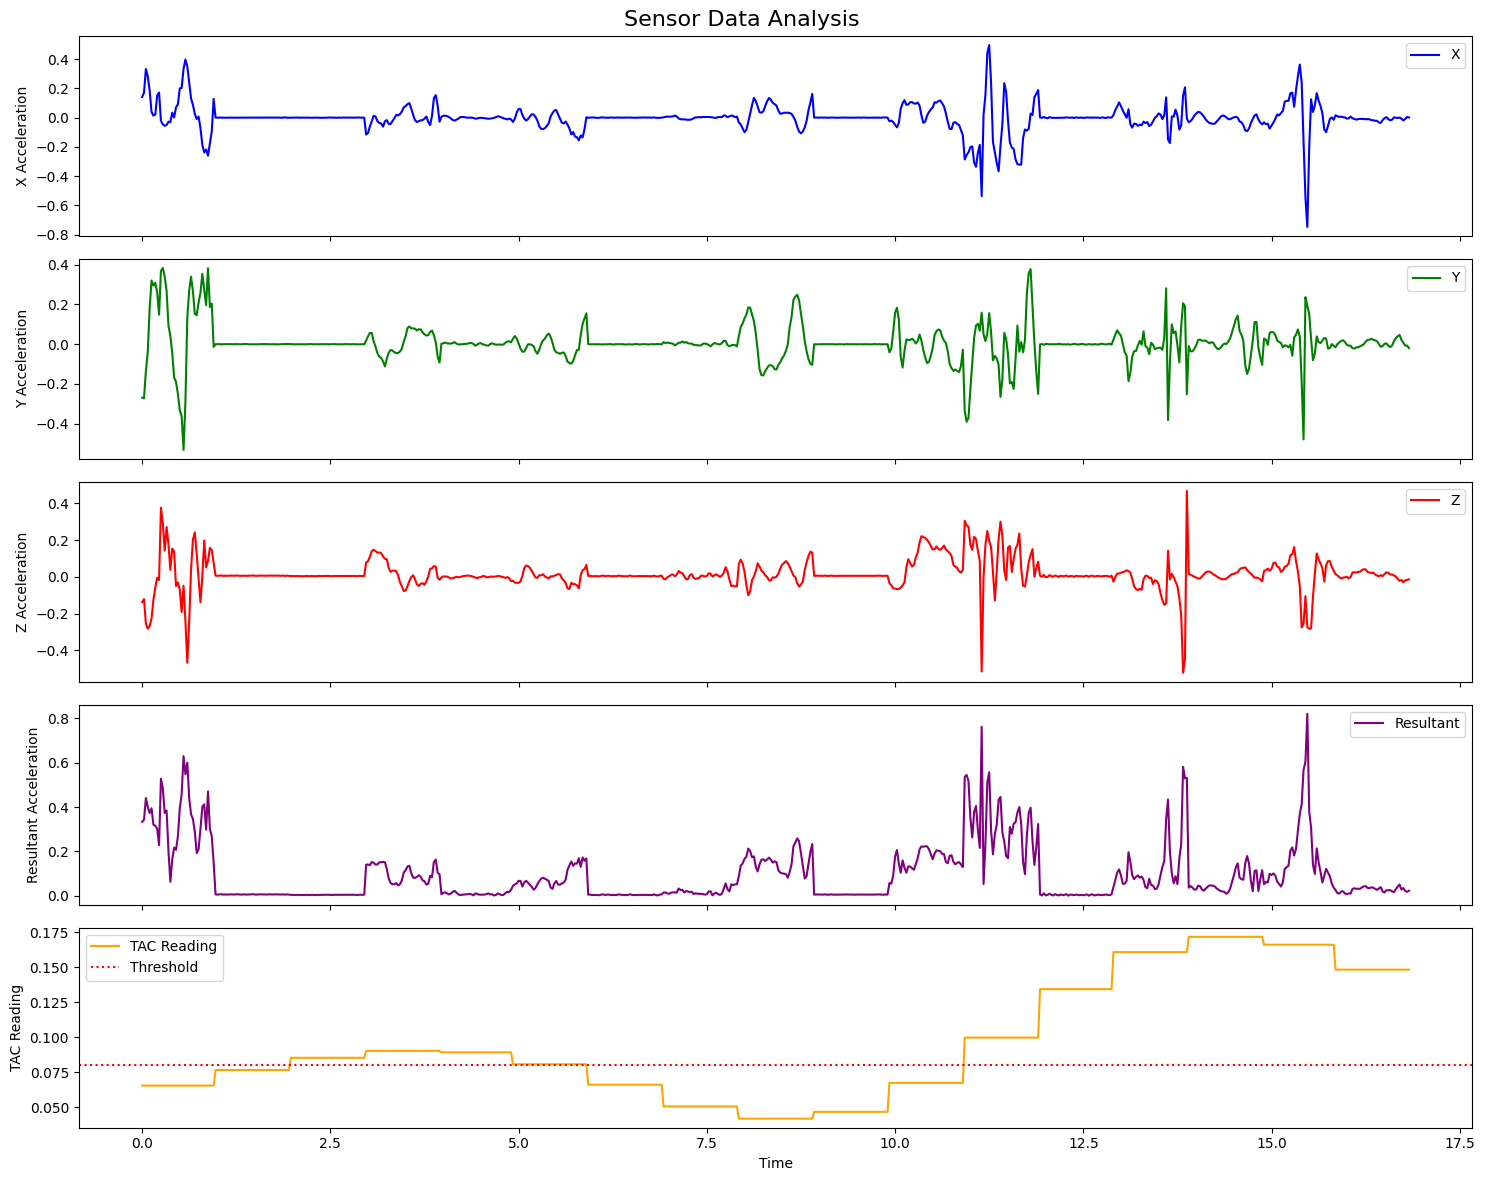

Reading TAC file of:  MJ8002
MJ8002_clean_TAC.csv
Merding with corresponding accelerometer data


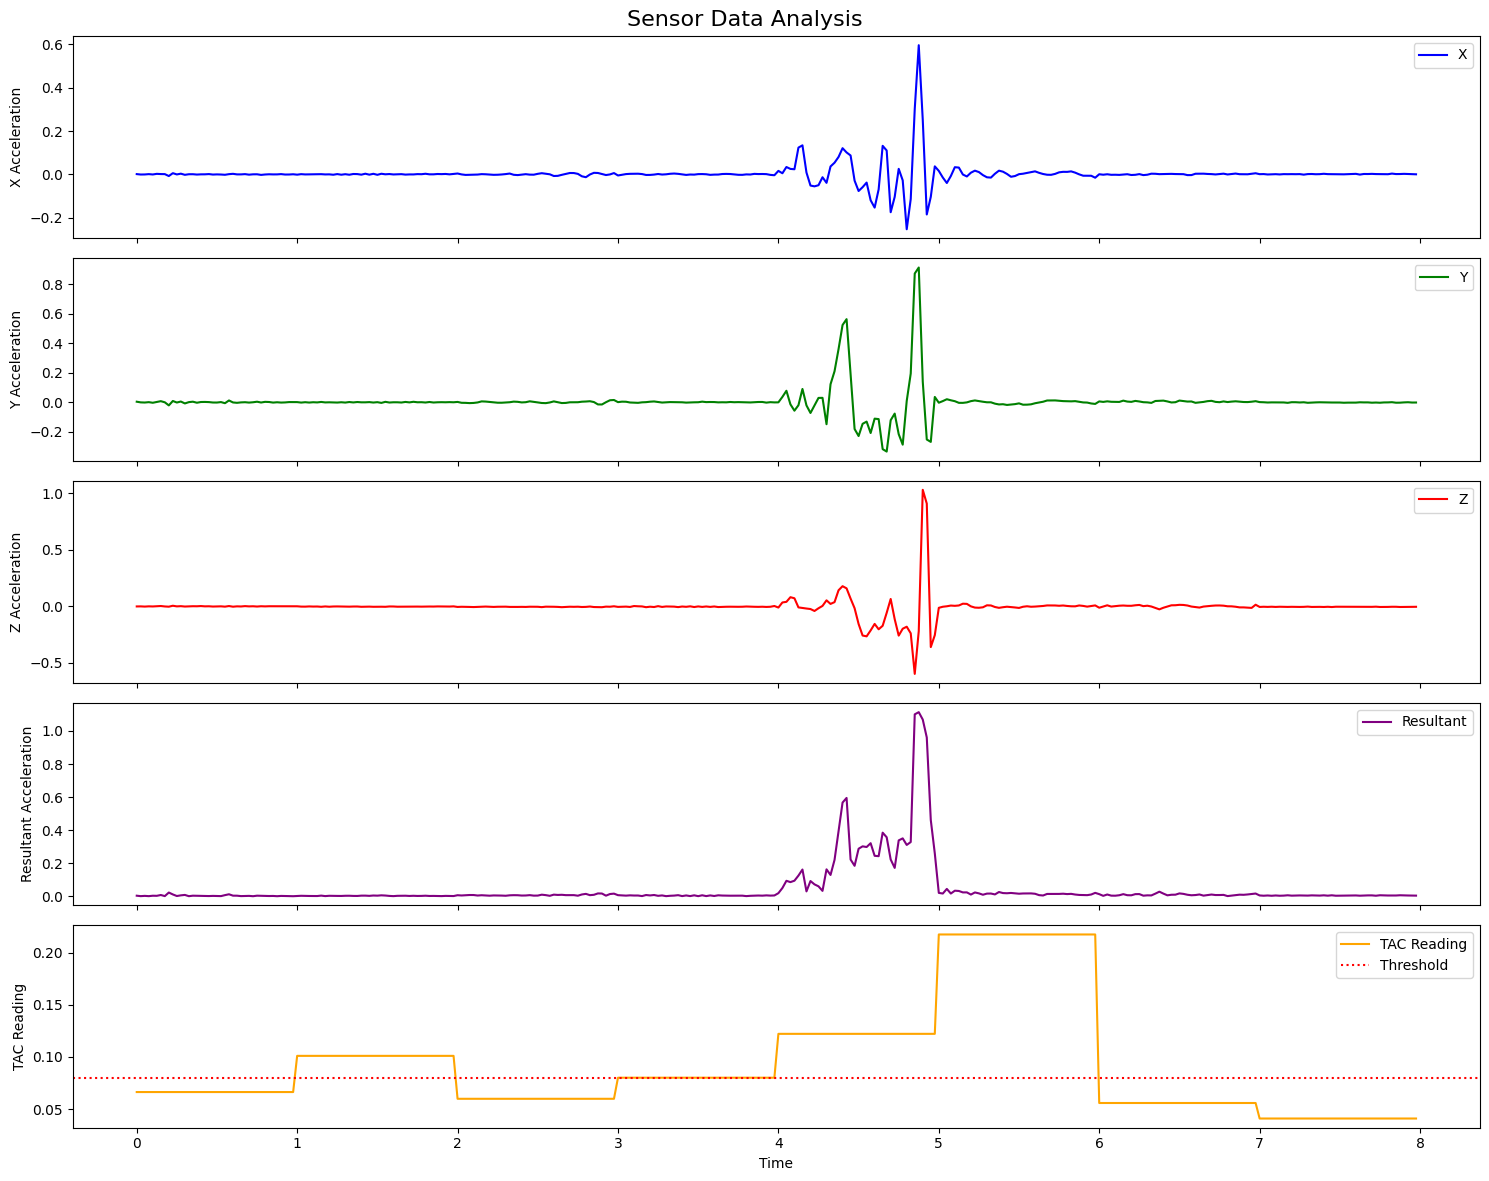

Reading TAC file of:  BU4707
BU4707_clean_TAC.csv
Merding with corresponding accelerometer data


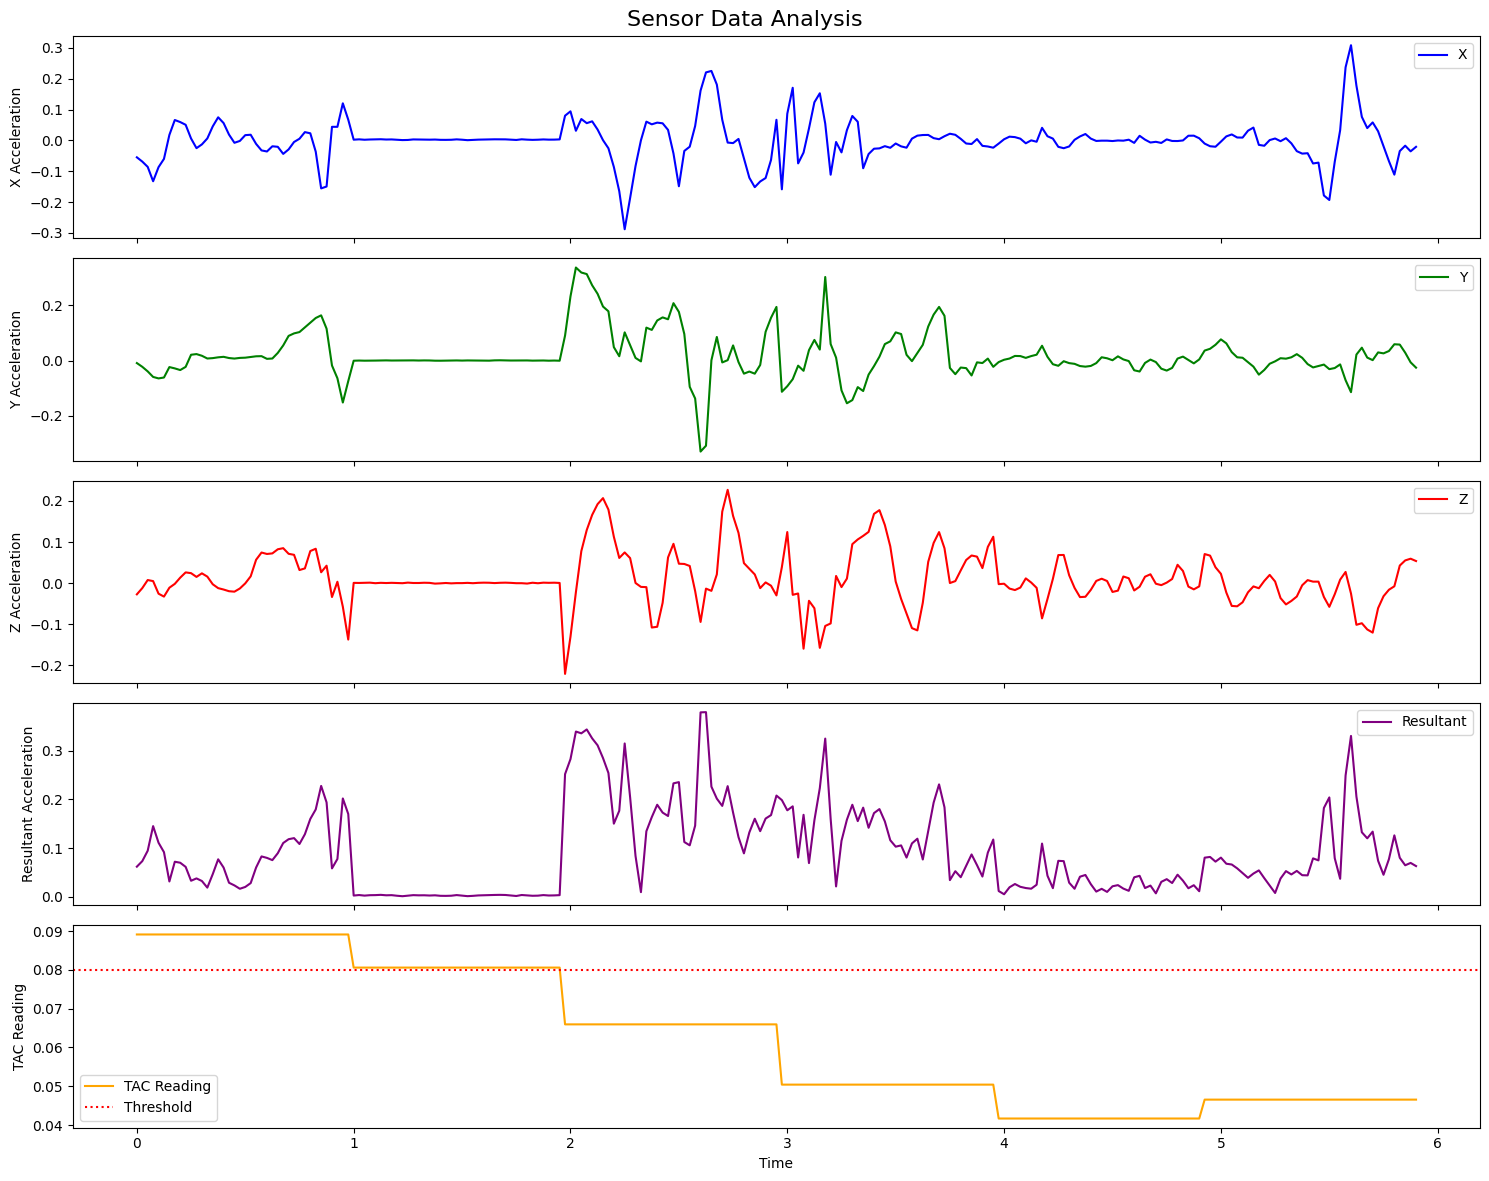

Reading TAC file of:  JR8022
JR8022_clean_TAC.csv
Merding with corresponding accelerometer data


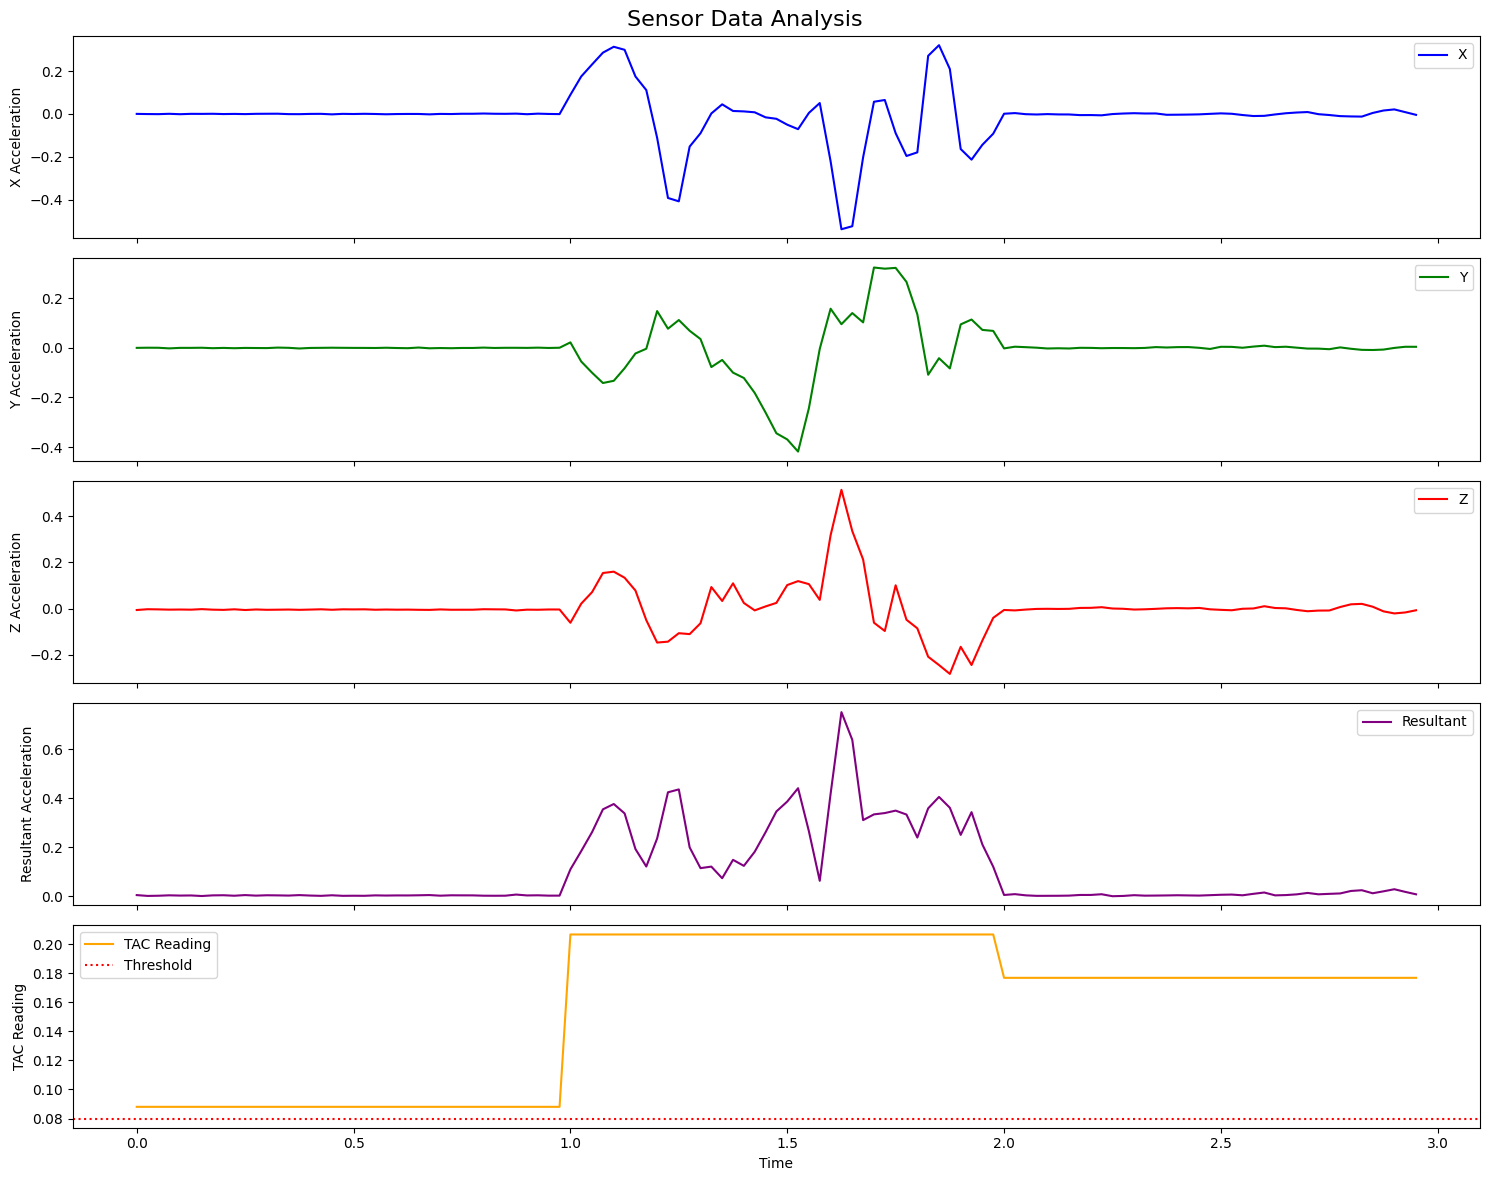

Reading TAC file of:  DC6359
DC6359_clean_TAC.csv
Merding with corresponding accelerometer data


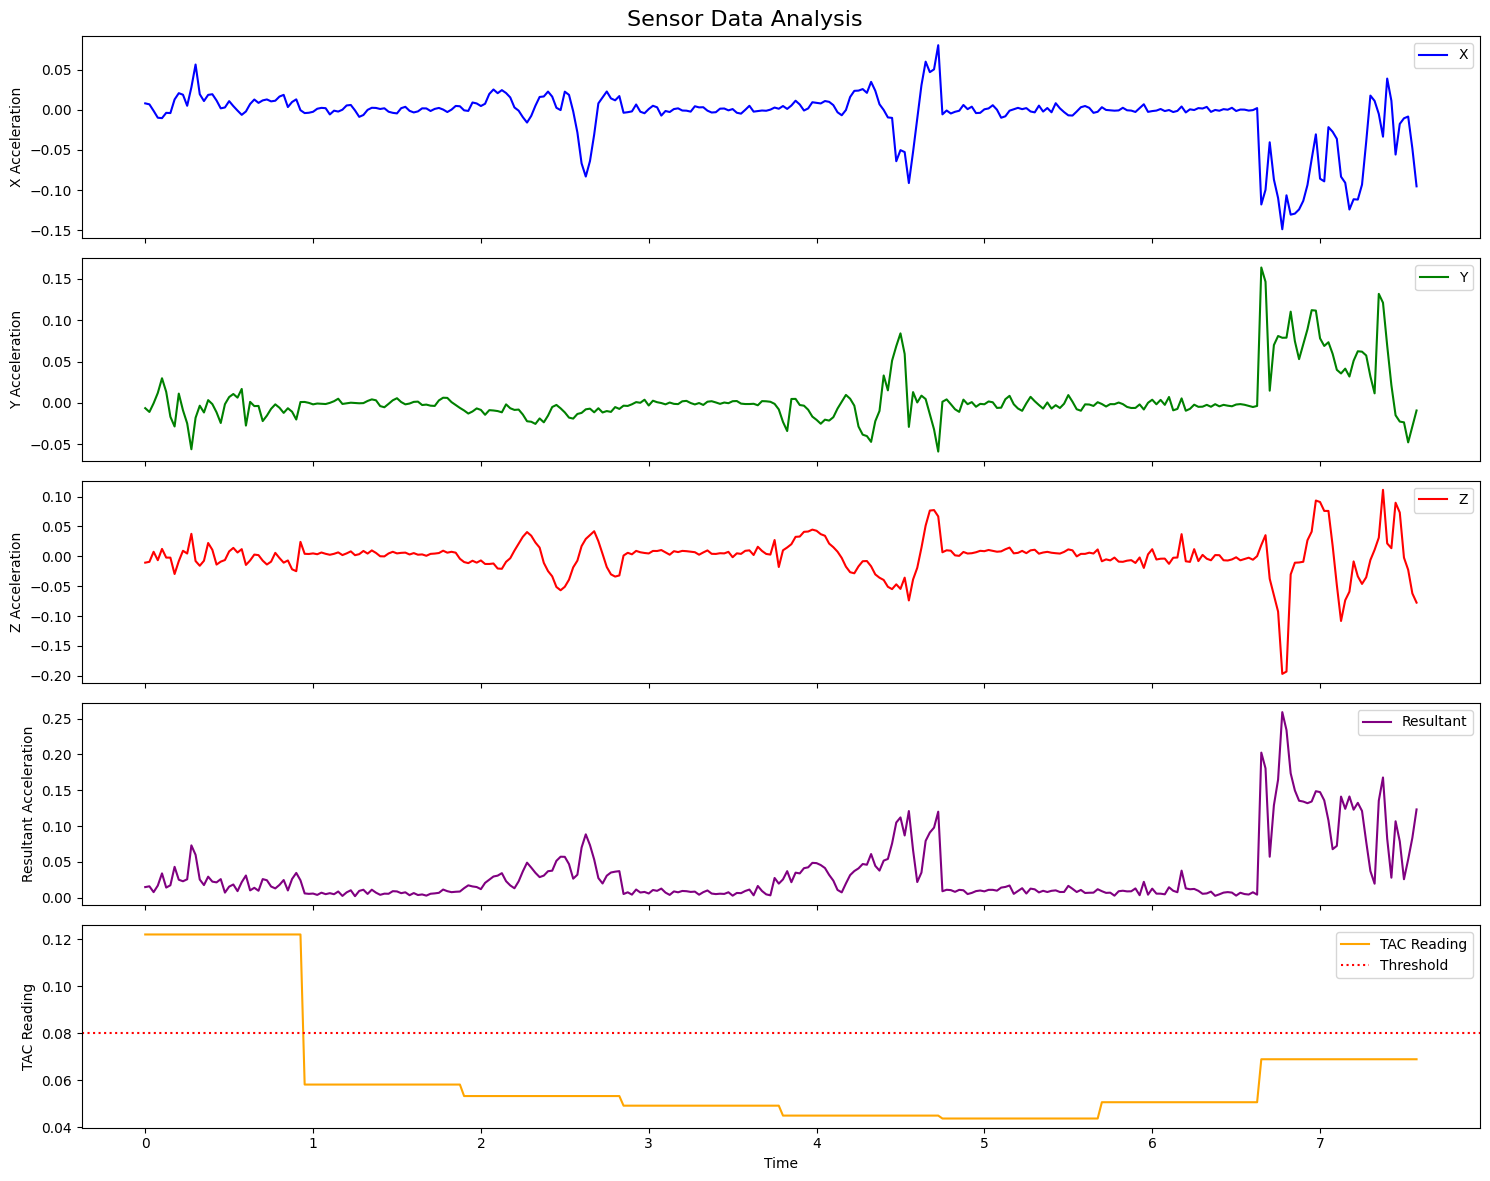

Reading TAC file of:  DK3500
DK3500_clean_TAC.csv
Merding with corresponding accelerometer data


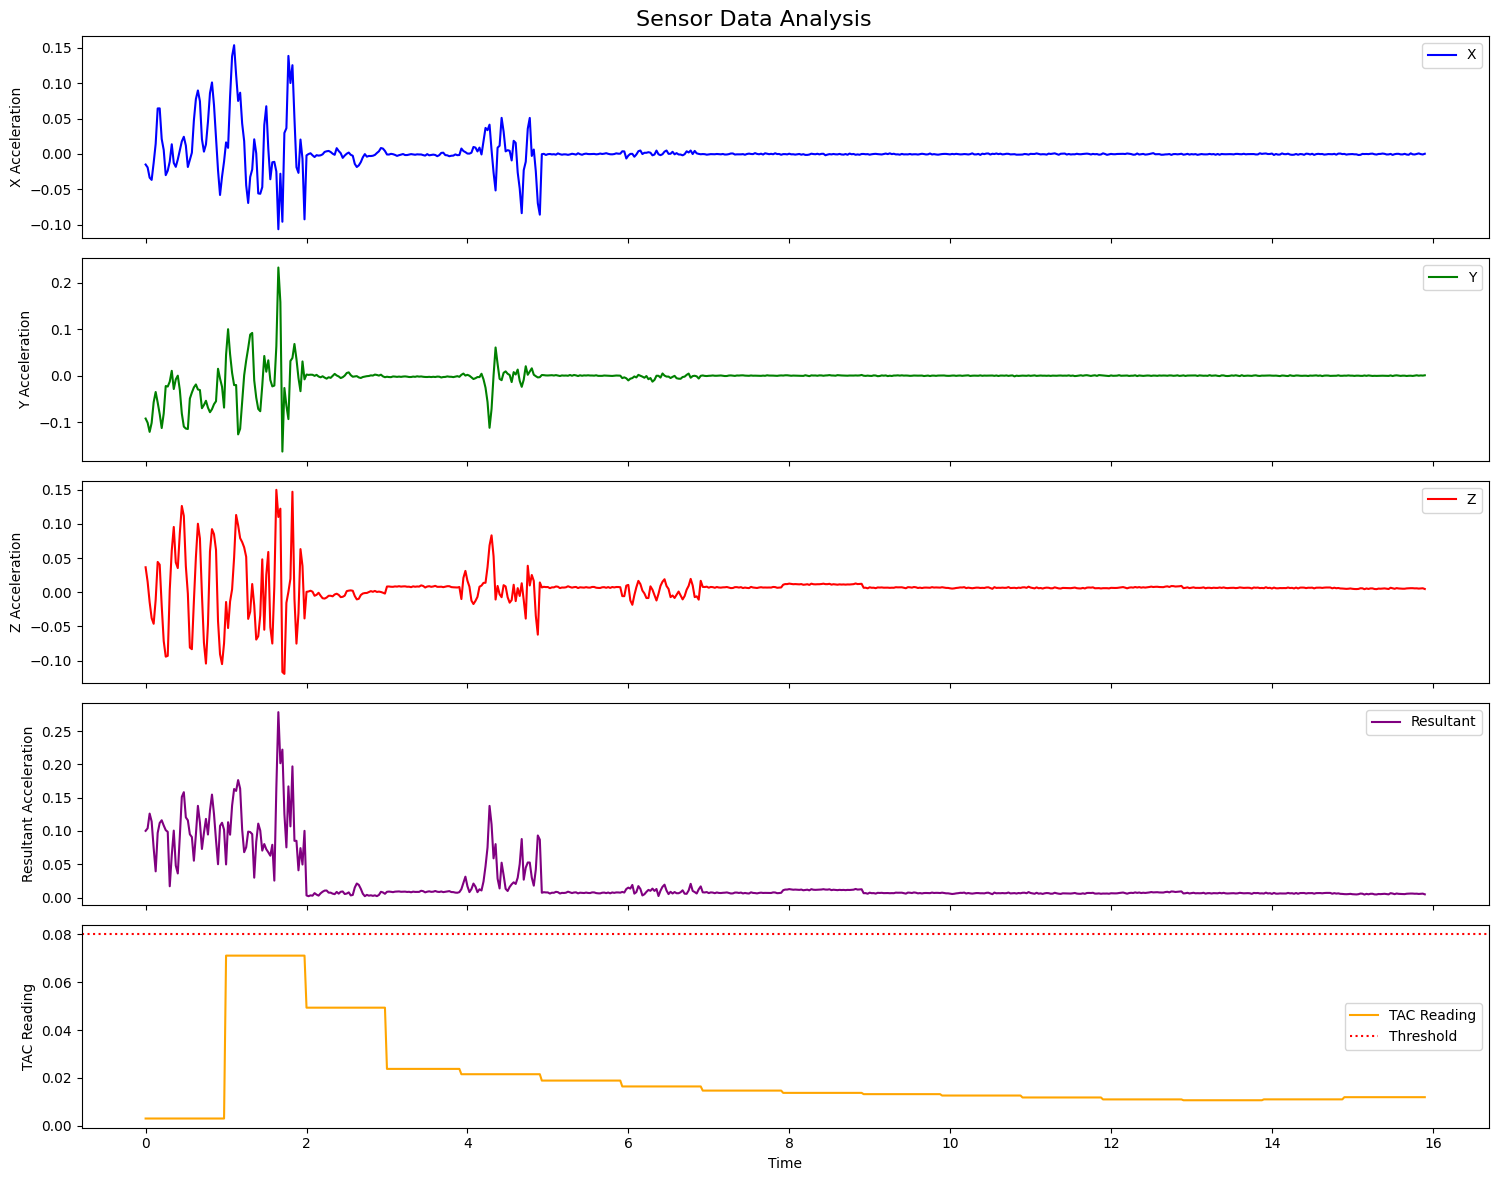

Reading TAC file of:  SF3079
SF3079_clean_TAC.csv
Merding with corresponding accelerometer data


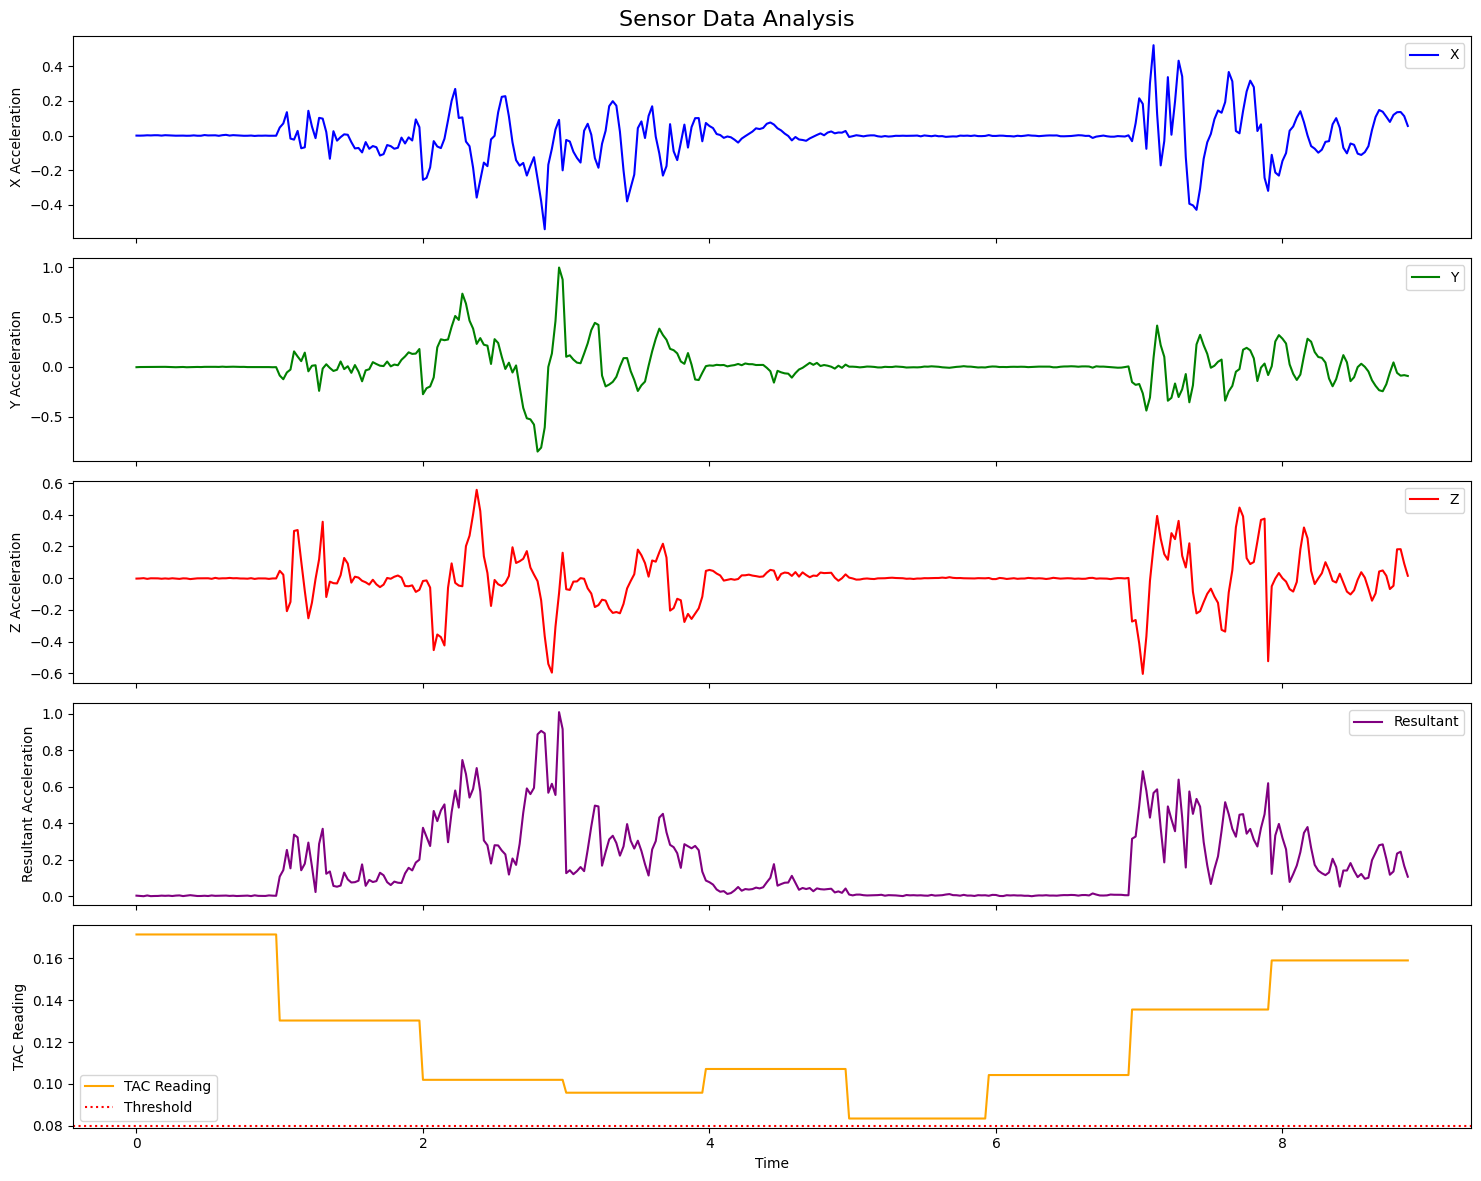

In [ ]:
df_perm_comp_data = accelerometer_tac_analysis(csv_files)

The new Dataframe contains
1. PID values: has the 13 different PID values
2. P_Entropy: has the p_entropy values calculated for a certain TAC for all PIDs
3. Complexity: has the complexity values calculated for a certain TAC for all PIDs
4. TAC: the corresponding TAC Values

In [ ]:
df_perm_comp_data

,pid,p_entropy,complexity,tac
0,SA0297,0.878524,0.111139,0.032672
1,SA0297,0.968564,0.030629,0.182644
2,SA0297,0.955894,0.040597,0.062414
3,SA0297,0.944480,0.056702,0.106077
4,SA0297,0.869955,0.107705,0.114999
...,...,...,...,...
4,SF3079,0.940166,0.058921,0.107148
5,SF3079,0.980675,0.019370,0.083469
6,SF3079,0.979660,0.019651,0.104253
7,SF3079,0.926469,0.068453,0.135561


Analysing the TAC Values for the new Dataframe

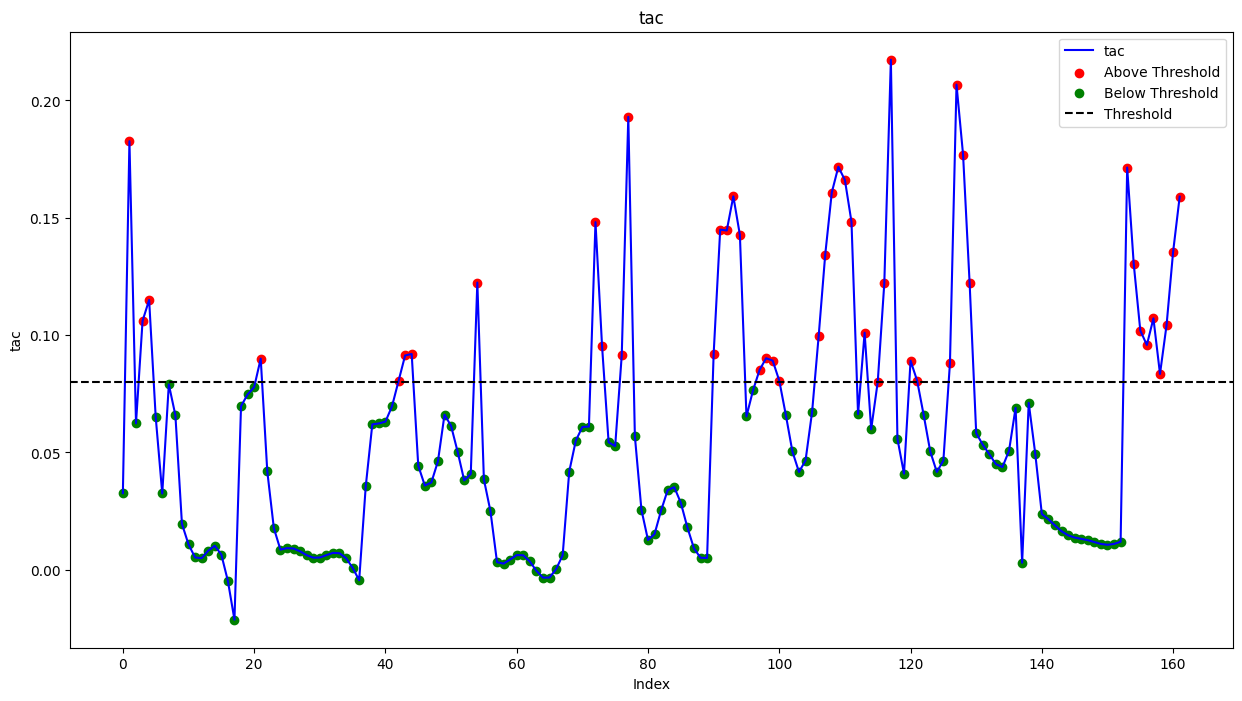

In [ ]:
# Visualizing the TAC Values
threshold = 0.08
plt.figure(figsize=(15,8))
df_perm_comp_data['tac'].plot(kind='line', color='blue', title='tac')

above_threshold = df_perm_comp_data[df_perm_comp_data['tac'] > threshold]
below_threshold = df_perm_comp_data[df_perm_comp_data['tac'] <= threshold]

plt.scatter(above_threshold.index, above_threshold['tac'], color='red', label='Above Threshold')
plt.scatter(below_threshold.index, below_threshold['tac'], color='green', label='Below Threshold')
plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')

plt.xlabel('Index')
plt.ylabel('tac')
plt.title('tac')
plt.legend()
plt.show()

Calculating the correlation coefficient for the columns to further investigate whether there is any relationship between p_entropy, complexity and TAC Values

In [ ]:
# Calculating Correlation Coefficient
corr = df_perm_comp_data[['p_entropy', 'complexity', 'tac']].corr()

In [ ]:
corr

,p_entropy,complexity,tac
p_entropy,1.000000,-0.498000,-0.043319
complexity,-0.498000,1.000000,0.196908
tac,-0.043319,0.196908,1.000000


<Axes: >

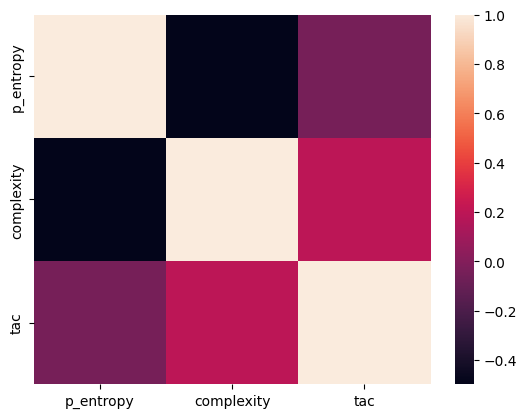

In [ ]:
# Visualizing the Correlations via heatmap
sns.heatmap(corr)

Plotting scatterplot for further confirming the results of the correlation heatmap

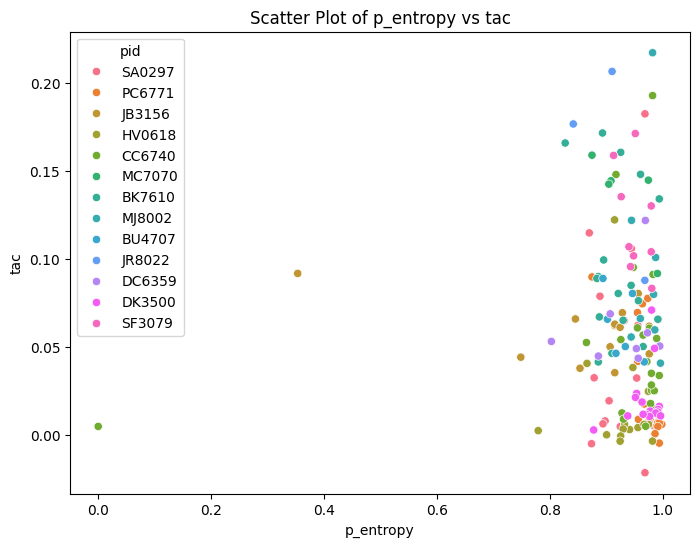

In [ ]:
# Scatter plot of p_entropy vs tac

df_perm_comp_data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_perm_comp_data, x='p_entropy', y='tac', hue='pid')
plt.xlabel('p_entropy')
plt.ylabel('tac')
plt.title('Scatter Plot of p_entropy vs tac')
plt.legend(title='pid')
plt.show()

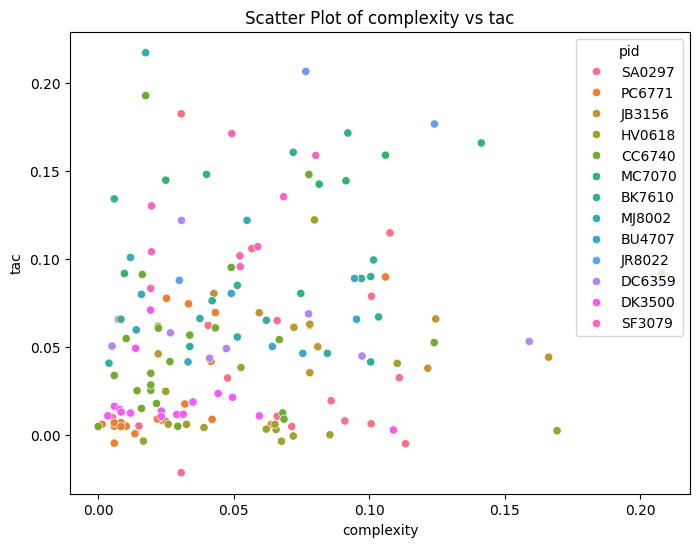

In [ ]:
# Scatter plot of complexity vs tac

df_perm_comp_data.reset_index(drop=True, inplace=True)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_perm_comp_data, x='complexity', y='tac', hue='pid')
plt.xlabel('complexity')
plt.ylabel('tac')
plt.title('Scatter Plot of complexity vs tac')
plt.legend(title='pid')
plt.show()

Plotting pair plot for an overall visualization

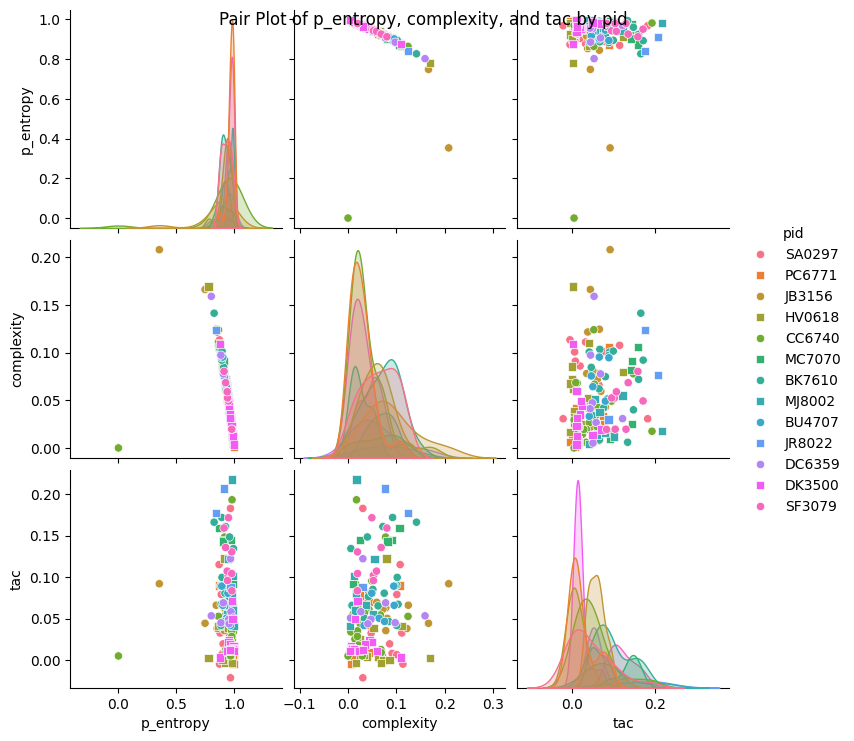

In [ ]:
# Pair plot for showing the relationship between all the values
sns.pairplot(df_perm_comp_data, hue='pid', markers=["o", "s"])
plt.suptitle('Pair Plot of p_entropy, complexity, and tac by pid')
plt.show()

## Insights

Correlation coefficients between p_entropy, complexity, and tac were displayed in the correlation matrix.

- Roughly speaking, the correlation coefficient between p_entropy and complexity
is -0.498. A moderately negative association has been seen. Though not quite linearly, complexity tends to decrease as p_entropy rises and vice versa.


- P_entropy and tac have a about -0.043 correlation. This suggests that there is very little negative association between tac and p_entropy. There is hardly any linear connection between p_entropy and tac.


- The correlation coefficient between complexity and tac is nearly 0.197.
This suggests a somewhat positive association between tac and complexity. Tac tends to grow slightly as complexity increases and vice versa, but the relationship is not very strong.



---



Examining each plot separately to offer more details from the scatter and pair plots and validate the correlation matrix's findings

Scatter Plot:
- There is no consistant pattern to the scattered points in the p_entropy vs. tac scatter plot. The correlation matrix indicates a weak negative correlation, which can be seen here as well, with the lack of any discernible trend or association between p_entropy and tac.

- There is noticeable variability in tac values for complexity values and vice versa. This suggests that complexity does not consistently predict tac, and vice versa. The data points exhibit a wide spread along both axes, indicating diverse values for each variable.

Pair Plot:
- In the pair plot, the distribution of each variable (p_entropy, complexity, and tac) is displayed by diagonal plots.
- Off-diagonal scatter plots reveal the relationships between the variables.
- Scatter plots of 'p_entropy' against 'complexity' and 'p_entropy' against 'tac' show no discernible linear relationship.
- The 'complexity' vs. 'tac' scatter plot displays scattered dots devoid of any obvious structure, indicating a poor relationship.




---



## Conclusion

- Consequently, it seems that there is no significant correlation between the TAC values and the P_entropy and Complexity levels.
- Although complexity and P_entropy are measures that are frequently linked to thought processes and behavioral patterns, there doesn't seem to be much of a relationship between them and TAC levels, which are a sign of alcohol intoxication, in this situation.
- The development of a more thorough and reliable intoxication prediction model may require taking into account additional variables or biomarkers.
- To find more characteristics or metrics that could provide more insight into an individual's degree of intoxication and improve the efficacy of intoxication detection systems, more research and analysis are required.



---



**References**
- Dataset from:
https://archive.ics.uci.edu/dataset/515/bar+crawl+detecting+heavy+drinking
- Permutation Entropy & Complexity functiions from:
https://github.com/srk-srinivasan/Permutation-Entropy
